 # Proyecto #2: Clustering.
 ----
  Universidad : UTEC \\
  Curso       : Inteligencia Artificial \\
  Profesor    : Cristian López Del Alamo
 ----

 Nombres y  Apellidos de Integrantes:
 - Integrante 1: Jean Melendez 100%
 - Integrante 2: Rodo Vilcarromero 100%
 - Integrante 3: Brhandon Gutierrez 100%
 - Integrante 4: Salvador Olivares 100%


Para esté proyeto, deberá utilizar la base de datos de **clase.txt** y **dataset_tissue.txt**.

# Librerias

In [ ]:
# Librerias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

# Cargar el csv


In [ ]:
# Cargar el csv
clase = pd.read_csv("./clase.txt")
data = pd.read_csv("./dataset_tissue.txt", skiprows=1, header=None).drop(0, axis=1).transpose()

#data = data.iloc[:, 1:]
#clase = clase.iloc[:, 1:]
print(data[1:])
print(clase[1:])

         0         1         2          3         4         5         6      \
2    10.509167  6.696075  7.775354  12.007817  5.180389  8.587241  6.962430   
3    10.272027  6.144663  7.696235  11.633279  5.301714  8.277414  7.054633   
4    10.252952  6.575153  8.478135  11.075286  5.372235  8.603650  7.115067   
5    10.157605  6.606701  8.116336  10.832528  5.334905  8.303227  7.078587   
6     9.966782  6.060069  7.644452  11.705062  5.253682  8.341625  7.120603   
..         ...       ...       ...        ...       ...       ...       ...   
185   9.803686  6.058488  7.486711   9.914632  5.312712  7.421166  6.906639   
186  10.509541  6.345526  7.468406   9.909784  5.341193  7.900080  6.982293   
187   9.984502  6.715984  7.120793   9.409933  4.896124  8.119396  6.810089   
188   9.937738  6.836179  7.125811   9.587782  5.296695  8.005432  6.976594   
189  10.306781  7.025547  7.407624   9.792904  5.206251  8.283758  7.123559   

        7         8         9      ...     22205   

# PCA

In [ ]:
# Componentes importantes
n= 7
pca = PCA(n_components=n)  # Reducción a 7 componentes principales
datos_reducidos_pca = pca.fit_transform(data)
print(datos_reducidos_pca)

df_pca = pd.DataFrame(data=datos_reducidos_pca, columns=[f"PC{i+1}" for i in range(n)])

[[-33.36763725 -27.601399    50.92606167 ...  21.69051321  -5.23030111
  -22.93771705]
 [-41.48310326 -36.99128399  36.45687417 ...  10.53134332  -0.73370458
   -4.64288701]
 [-41.32311415   3.8035407   36.12911397 ...  48.14453587   0.65699609
  -38.72173158]
 ...
 [-43.96330782 -36.2730025  -11.02132248 ... -48.88683183  99.18316917
  -33.29993129]
 [-45.48406094 -24.41609103 -21.33784778 ... -36.52675231 101.97758113
  -24.63907763]
 [-51.8981521  -22.01633933 -27.14429492 ... -34.96073666 108.37172991
  -27.63683472]]


# GMM

In [ ]:
def inicializar_parametros(data, n_clusters):
    # Inicializamos las medias utilizando K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100).fit(data)
    means = kmeans.cluster_centers_

    # Inicializamos las matrices de covarianza basadas en la covarianza de los datos reales.
    covarianzas_data = np.cov(data, rowvar=False)
    covarianza = [covarianzas_data.copy() for _ in range(n_clusters)]

    # Inicializamos las probabilidades de cada cluster
    probabilidad = np.ones(n_clusters) / n_clusters

    return means, covarianza, probabilidad

def funcion_probabilidad(X, media, desviacion_estandar):
    d = X.shape[0]
    determinante_covarianza = np.linalg.det(desviacion_estandar)
    inversa_covarianza = np.linalg.inv(desviacion_estandar)

    factor1 = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(determinante_covarianza))
    factor2 = np.exp(-0.5 * np.dot(np.dot((X - media).T, inversa_covarianza), (X - media)))

    return factor1 * factor2

def probabilidad_posteriori(X, media, desviacion_estandar, pi):
    n_clusters = len(media)
    Yz = np.zeros((len(X), n_clusters))
    for j in range(len(X)):
        for i in range(n_clusters):
            prob = funcion_probabilidad(X[j], media[i], desviacion_estandar[i])
            Yz[j][i] = pi[i] * prob

        Yz[j] /= np.sum(Yz[j])

    return Yz

def EM(data, n_clusters, n_iter=100, tolerancia=1e-5):
    means, covarianza, probabilidad = inicializar_parametros(data, n_clusters)

    # Inicializamos la lista de log-likelihoods
    log_likelihoods = []

    for _ in range(n_iter):
        Yz = probabilidad_posteriori(data, means, covarianza, probabilidad)

        # Actualizamos los parametros
        Nk = np.sum(Yz, axis=0)
        for k in range(n_clusters):
            means[k] = np.sum(data * Yz[:, k][:, np.newaxis], axis=0) / Nk[k]
            cov_actualizar = np.dot((data - means[k]).T, (data - means[k]) * Yz[:, k][:, np.newaxis]) / Nk[k]
            cov_actualizar += tolerancia * np.eye(data.shape[1])
            covarianza[k] = cov_actualizar
            probabilidad[k] = Nk[k] / len(data)

        # Calculamos el log-likelihood
        log_likelihood = np.sum(np.log(np.sum(Yz, axis=1)))
        log_likelihoods.append(log_likelihood)

        # Comprobamos si el algoritmo ha convergido
        if len(log_likelihoods) > 1 and abs(log_likelihood - log_likelihoods[-2]) < tolerancia:
            break

    return means, covarianza, probabilidad

def entrenamiento(data, n_clusters, n_iter=100, tolerancia=1e-5):
    return EM(data, n_clusters, n_iter, tolerancia)

def prediccion(data, means, covarianza, probabilidad):
    # Calculamos la probabilidad posteriori para cada punto de datos
    Yz = probabilidad_posteriori(data, means, covarianza, probabilidad)
    # Asignamos la etiqueta de cluster a cada punto de datos
    return np.argmax(Yz, axis=1)

<ipython-input-16-564aad519eb3>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distancias, method='ward')


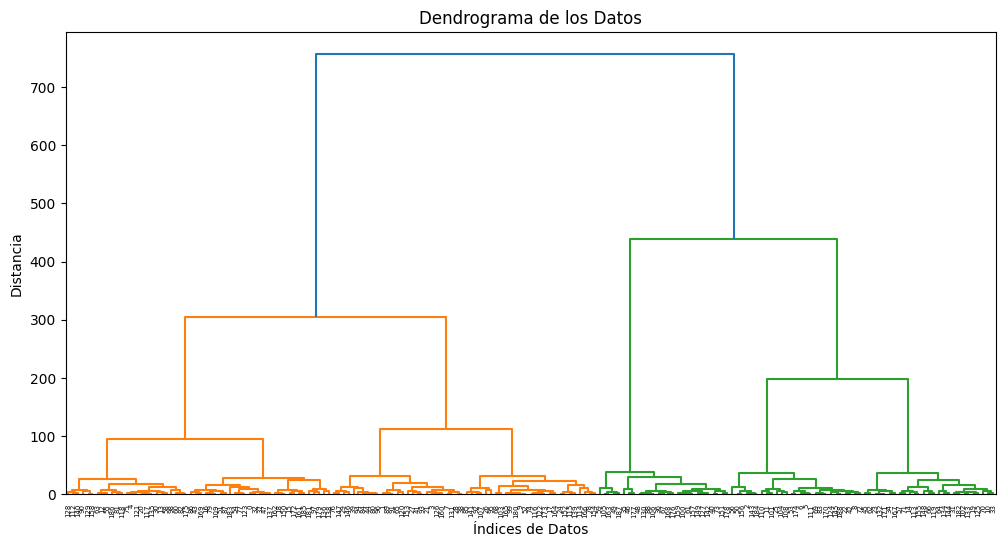

Silhouette Score: 0.41705135856178455
Adjusted Rand Index: 0.0038109979321255556
Homogeneity: 0.05030214672988543
Completeness: 0.05697562049562039
V-Measure: 0.05343131380004262


In [ ]:
# Calcular la matriz de enlaces utilizando la distancia euclidiana
distancias = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distancias[i, j] = np.linalg.norm(X[i] - X[j])

# Generar el dendrograma utilizando scipy
linkage_matrix = linkage(distancias, method='ward')

# Mostrar el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Dendrograma de los Datos')
plt.xlabel('Índices de Datos')
plt.ylabel('Distancia')
plt.show()



silhouette = silhouette_score(X, prediccion_clusters)
ari = adjusted_rand_score(clase_true, prediccion_clusters)

homogeneity = homogeneity_score(clase_true, prediccion_clusters)
completeness = completeness_score(clase_true, prediccion_clusters)
v_measure = v_measure_score(clase_true, prediccion_clusters)

print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

<ipython-input-11-63762b8b4849>:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], 180 + angle, color='black')


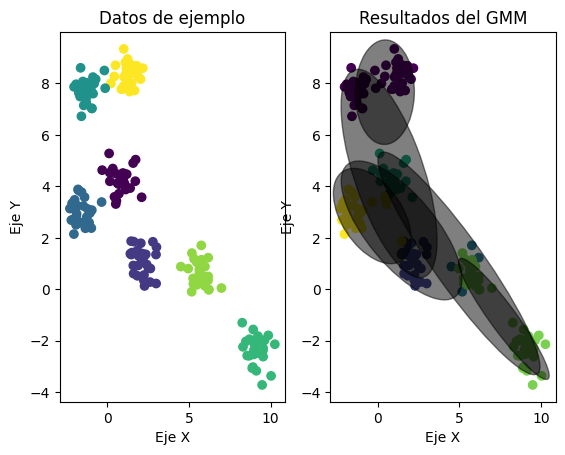

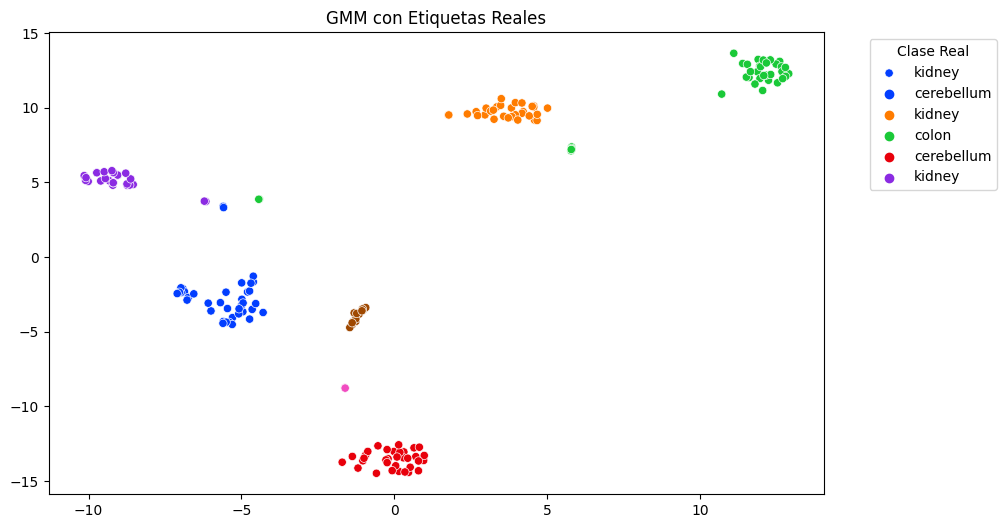

In [ ]:
 # Generar datos de ejemplo
n_samples = df_pca.shape[0]
centers = df_pca.shape[1]
X, y_true = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.5, random_state=0)

# Ejecutar el algoritmo de mezcla gaussiana
n_clusters = 6
means, covarianza, probabilidad = entrenamiento(X, n_clusters)

# Realizar la predicción de los clusters
prediccion_clusters = prediccion(X, means, covarianza, probabilidad)

# Graficar los datos y los clusters
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis')
plt.title('Datos de ejemplo')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=prediccion_clusters, cmap='viridis')
plt.title('Resultados del GMM')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Centros de las distribuciones gaussianas
for mean, cov in zip(means, covarianza):
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi # convertir a grados
    ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], 180 + angle, color='black')
    ell.set_clip_box(plt.gca().bbox)
    ell.set_alpha(0.5)
    plt.gca().add_artist(ell)

# Agregar la leyenda y graficar los datos reales
clase_true_path = 'clase.txt'
clase_true = pd.read_csv(clase_true_path, header=None, skiprows=1, usecols=[1]).values.flatten()
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(df_pca)

most_common_labels = []
for i in range(n_clusters):
    most_common_label = Counter(clase_true[prediccion_clusters == i]).most_common(1)[0][0]
    most_common_labels.append(most_common_label)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=clase_true, palette='bright')
plt.legend(most_common_labels, title='Clase Real', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('GMM con Etiquetas Reales')
plt.show()

# K-Means

In [ ]:
# Implementación de K-means
def distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def init_centroids(data, k):
    initial_centroids = random.sample(list(data), k)
    return initial_centroids

def return_new_centroids(grupos, data, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[grupos == i]
        if cluster_points.size > 0:
            new_centroids[i] = np.mean(cluster_points, axis=0)
    return new_centroids

def get_clusters(data, centroids):
    clusters = []
    for punto in data:
        distances = [distance(punto, centroide) for centroide in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def average_centroid_distance(old_centroids, new_centroids):
    return np.mean([distance(old_centroids[i], new_centroids[i]) for i in range(len(old_centroids))])

def kmeans(data, k, threshold):
    centroids = init_centroids(data, k)
    clusters = get_clusters(data, centroids)
    new_centroids = return_new_centroids(clusters, data, k)
    while average_centroid_distance(centroids, new_centroids) > threshold:
        centroids = new_centroids
        clusters = get_clusters(data, centroids)
        new_centroids = return_new_centroids(clusters, data, k)
    return new_centroids, clusters


In [ ]:
# Ejecutamos kmeans
k = 6
umbral = 0.0001
centroides, clusters = kmeans(df_pca.to_numpy(), k, umbral)
print("CENTROIDES", centroides)
print("CLUSTERS", clusters)

# Convertir los valores de color a formato numérico
cluster_colors = [int(cluster) for cluster in clusters]

# Obtener valores únicos en clusters para mostrar el número de clústeres
unique_clusters = np.unique(clusters)
print(f"Se encontraron {len(unique_clusters)} clústeres")


CENTROIDES [[-35.12462199 -17.11976894  37.43482683  -3.0088048   28.61433181
   -0.30535131 -10.90018819]
 [-33.20434301 -40.35764003 -20.99283276   0.33610162 -11.8267971
    1.60997971   6.30175356]
 [ 86.86921136  12.12118397 -15.01293305 -38.3729738    7.5078976
   -1.73218445  -0.88126061]
 [-25.29042411  53.34519605 -57.68187199  25.34217489  58.0504098
   36.18322576  19.57041592]
 [-76.56218852  76.33639134   1.98345878  -8.67188147 -20.73498771
   -8.90210012   0.6080541 ]
 [ 67.2816499    9.03334391  14.81684319  37.17984671 -13.65733377
   -0.75005886  -1.33294995]]
CLUSTERS [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 4 4 4 0 0 0 4 4 4 0 0 2 5 4 4 4 4 4 4 3 3 3 3 3 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 2 2 2 1 1
 1 1 1 1]
Se encontraron 6 clús

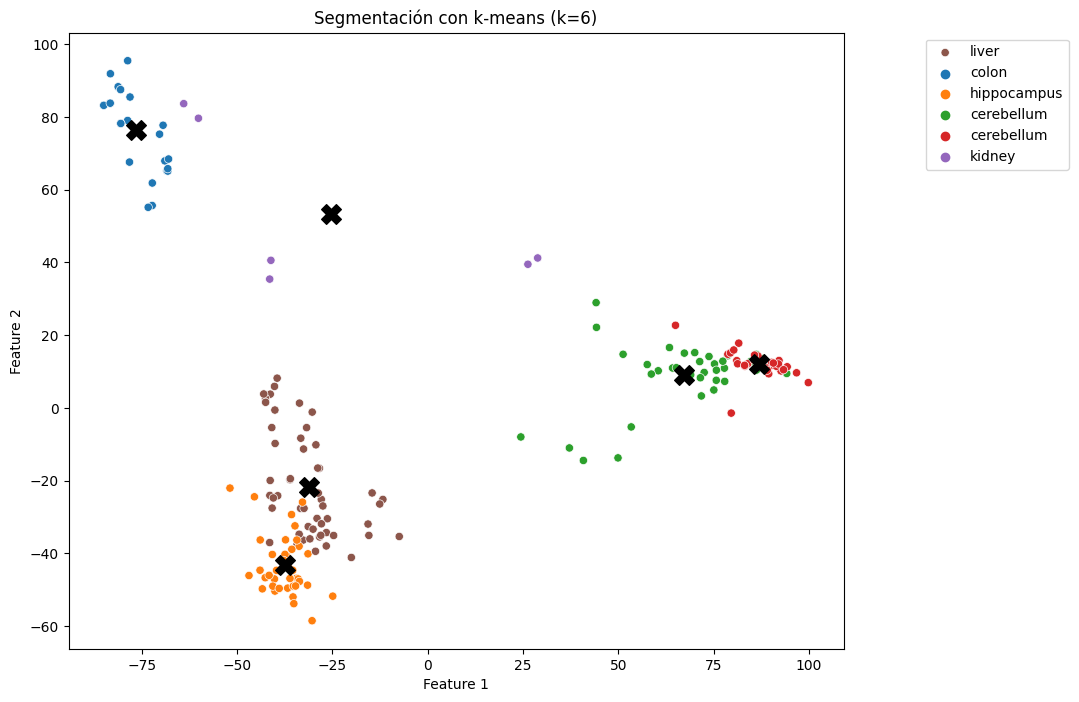

In [ ]:
# Obtener las etiquetas verdaderas desde 'clase.txt'
clase_true_path = 'clase.txt'
clase_true = pd.read_csv(clase_true_path, header=None, skiprows=1, usecols=[1]).values.flatten()

# Visualización de los resultados
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x="PC1", y="PC2", hue=cluster_colors, palette="tab10", data=df_pca)
plt.scatter(centroides[:, 0], centroides[:, 1], marker="X", color="black", s=200, label="Centroides")

# Crear la leyenda
most_common_labels = []
for i in range(k):
    most_common_label = Counter(clase_true[clusters == i]).most_common(1)[0][0]
    most_common_labels.append(most_common_label)
legend_labels = [f"{label}" for i, label in enumerate(most_common_labels)]
scatter.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title(f"Segmentación con k-means (k={k})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

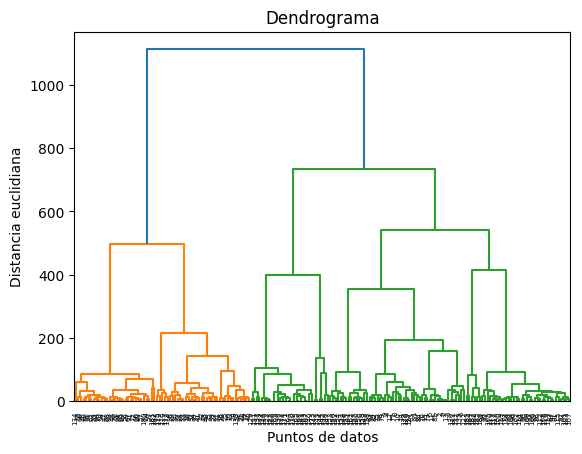

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calcula la matriz de enlace jerárquico
dendrogram = sch.dendrogram(sch.linkage(df_pca, method='ward'))

plt.title('Dendrograma')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia euclidiana')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
import numpy as np

# Silhouette Score
silhouette_avg = silhouette_score(df_pca, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Score
davies_bouldin_avg = davies_bouldin_score(df_pca, clusters)
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')

# Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(df_pca, clusters)
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(clase_true, clusters)
print(f'Adjusted Rand Index (ARI): {ari}')

# Homogeneidad
homogeneity = homogeneity_score(clase_true, clusters)
print(f'Homogeneidad: {homogeneity}')

# Completitud
completeness = completeness_score(clase_true, clusters)
print(f'Completitud: {completeness}')

# Puntuación V-Measure
v_measure = v_measure_score(clase_true, clusters)
print(f'Puntuación V-Measure: {v_measure}')

Silhouette Score: 0.5560771406776509
Davies-Bouldin Score: 0.7408217507700243
Calinski-Harabasz Score: 150.66605805995064
Adjusted Rand Index (ARI): 0.757654463804784
Homogeneidad: 0.8005311274732142
Completitud: 0.8817183064377987
Puntuación V-Measure: 0.8391656263785212


# DBSCAN

In [ ]:
# Calcular la matriz de distancias
def distance_matrix(data):
    num_samples = len(data)
    dist_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(i, num_samples):
            dist_matrix[i][j] = np.linalg.norm(data[i] - data[j])
            dist_matrix[j][i] = dist_matrix[i][j]
    return dist_matrix

# Algoritmo DBSCAN
def dbscan(data, eps, min_samples):
    dist_matrix = distance_matrix(data)
    num_samples = len(data)
    labels = np.zeros(num_samples)  # Etiquetas de los clusters
    current_cluster = 0

    for i in range(num_samples):
        if labels[i] != 0:
            continue

        neighbors = []
        for j in range(num_samples):
            if dist_matrix[i][j] < eps:
                neighbors.append(j)

        if len(neighbors) < min_samples:
            labels[i] = -1  # Marcar como ruido (outlier)
        else:
            current_cluster += 1
            labels[i] = current_cluster
            expand_cluster(data, dist_matrix, labels, i, neighbors, current_cluster, eps, min_samples)

    return labels

# Expandir un cluster
def expand_cluster(data, dist_matrix, labels, point_index, neighbors, current_cluster, eps, min_samples):
    for neighbor in neighbors:
        if labels[neighbor] == -1:
            labels[neighbor] = current_cluster  # Asignar a un cluster válido
        elif labels[neighbor] == 0:
            labels[neighbor] = current_cluster
            new_neighbors = []
            for j in range(len(data)):
                if dist_matrix[neighbor][j] < eps:
                    new_neighbors.append(j)
            if len(new_neighbors) >= min_samples:
                neighbors.extend(new_neighbors)



In [ ]:
# Parámetros para DBSCAN
eps = 20  # Radio de vecindad
min_samples = 6 # Número mínimo de puntos para formar un clúster

data2 = datos_reducidos_pca
# Ejecutar DBSCAN en los datos normalizados
dbscan_labels = dbscan(data2, eps, min_samples)

# Mostrar los resultados
print("Resultados de DBSCAN:")
print(dbscan_labels)

Resultados de DBSCAN:
[-1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  2.  2.
 -1.  2. -1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  1.  4.  4.  1. -1.  4.  4. -1.  1.  4.  4.  4. -1.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5. -1.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5. -1. -1. -1.  6.  6.  6.
 -1. -1.  4. -1.  6. -1. -1. -1. -1. -1.  6. -1.  7. -1.  6.  7. -1. -1.
 -1. -1. -1. -1.  8. -1.  8.  8.  8.  8.  8.  8.  9.  9. -1.  9.  9.  9.
  9.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7. -1. -1. -1. -1. -1.
  3. -1. -1. -1. -1. -1. -1. -1. -1.]


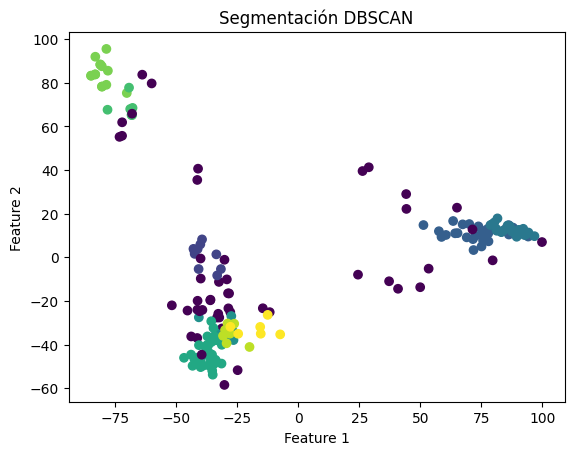

In [ ]:
# Convierte los valores de color a formato numérico
cluster_colors_dbscan = [int(label) for label in dbscan_labels]

# Graficar los datos
plt.scatter(data2[:, 0], data2[:, 1], c=cluster_colors_dbscan, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Segmentación DBSCAN')
plt.show()

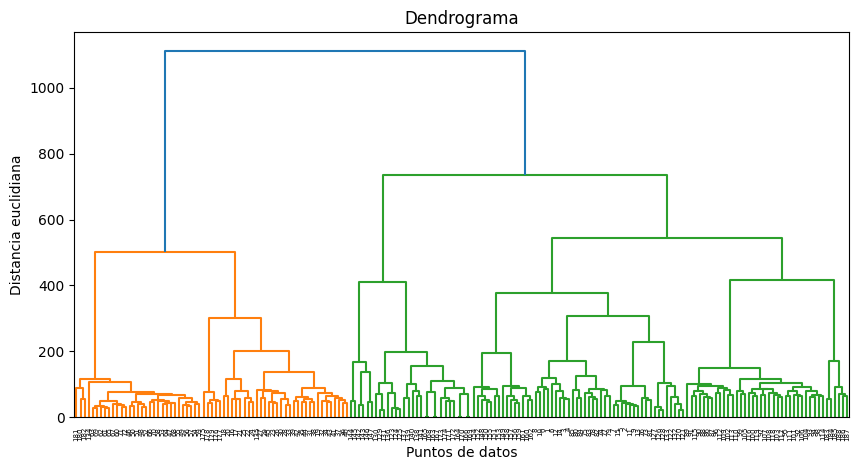

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Calcular el dendrograma
def plot_dendrogram(data2, method='ward'):
    linkage_matrix = linkage(data2, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title("Dendrograma")
    plt.xlabel('Puntos de datos')
    plt.ylabel('Distancia euclidiana')

    plt.show()

plot_dendrogram(data, method='ward')

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
# Calcular métricas
silhouette = silhouette_score(data2, dbscan_labels)
davies_bouldin = davies_bouldin_score(data2, dbscan_labels)
calinski_harabasz = calinski_harabasz_score(data2, dbscan_labels)
# Usamos las etiquetas
adjusted_rand = adjusted_rand_score(dbscan_labels, clase_true)
homogeneity = homogeneity_score(dbscan_labels, clase_true)
completeness = completeness_score(dbscan_labels, clase_true)
v_measure = v_measure_score(dbscan_labels, clase_true)

# Imprimir las métricas
print("Silhouette Score:", silhouette)
print("Davies Bouldin Score:", davies_bouldin)
print("Calinski Harabasz Score:", calinski_harabasz)
print("Adjusted Rand Score:", adjusted_rand)
print("Homogeneity Score:", homogeneity)
print("Completeness Score:", completeness)
print("V-Measure Score:", v_measure)

Silhouette Score: 0.39539164870012056
Davies Bouldin Score: 1.2142818757011002
Calinski Harabasz Score: 56.660999020389006
Adjusted Rand Score: 0.5725974832497558
Homogeneity Score: 0.697943718896574
Completeness Score: 0.7765956178499726
V-Measure Score: 0.735172023008781


# Agglomerative Hierarchical Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


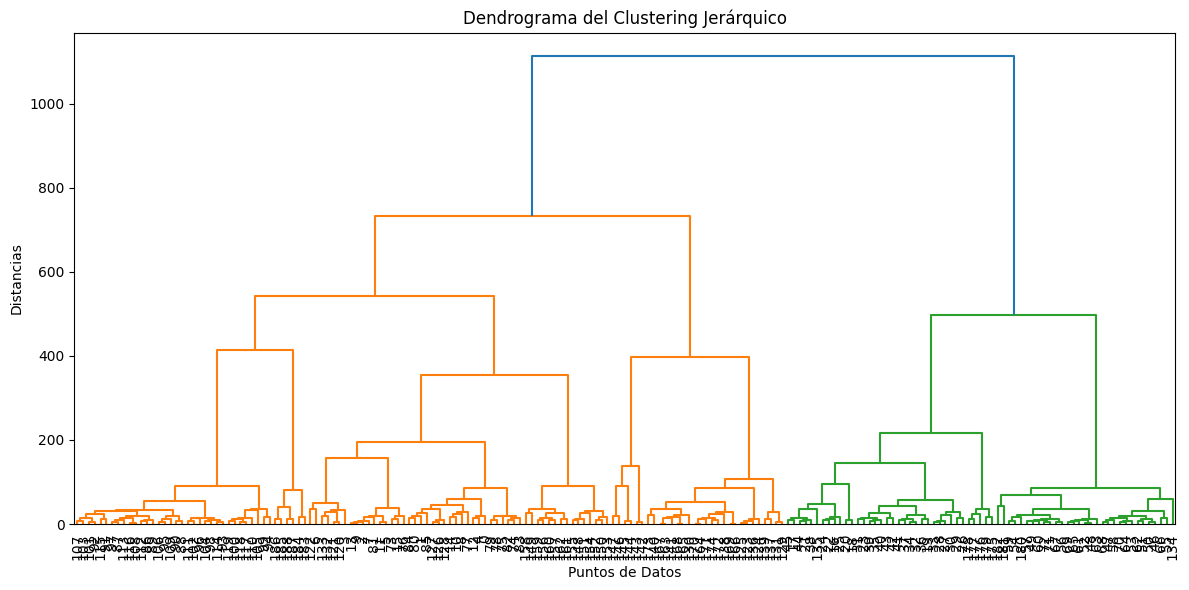

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

X_reduced = df_pca.to_numpy()

# Corregir el uso de AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
model.fit(X_reduced)

# Obtener la matriz de linkage usando SciPy
Z = linkage(X_reduced, method='ward')

# Visualizar el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Puntos de Datos')
plt.xticks(fontsize=10)
plt.ylabel('Distancias')
plt.tight_layout()
plt.show()